In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
from util import Net, r, l

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [3]:
data_train = datasets.MNIST(root = "./data/",
                train = True,
                transform = ToTensor(),
                download = True)

data_test = datasets.MNIST(root="./data/",
              transform = ToTensor(),
              train = False,
              download=True)  

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                        batch_size = 64,
                        shuffle = True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                        batch_size = 64,
                        shuffle = True)

In [4]:
model_path = './model/mnist_classifier'

print(torch.load(model_path))
minist_classifier = torch.load(model_path)

Net(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


为了简单只使用了全连接网络。

In [5]:
class AAE_ATN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 2048),
            nn.Sigmoid(),
            nn.Linear(2048, 2048),
            nn.Sigmoid(),
            nn.Linear(2048, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = x.view(x.size()[0], -1)
        out = self.fc(out)
        out = out.view(out.size()[0], 1, 28, 28)
        return out
        
model_AAE = AAE_ATN().to(device)

In [6]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model_AAE.parameters(), lr=learning_rate)
loss_fn = l
target = 5
b = 1500

In [7]:
def train(dataloader, model, target_model, loss_fn, optimizer):
    model.train()
    for param in target_model.parameters():
        param.requires_grad = False
    size = len(dataloader.dataset)
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        optimizer.zero_grad()
        target_model.zero_grad()
        generate = model(X)
        # generate = torch.clamp(generate, 0, 1)
        pred_raw = target_model(X)
        pred_generate = target_model(generate) 

        loss = loss_fn(X, generate, pred_raw, pred_generate, b, target, r)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item() / len(X), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(data_loader_train, model_AAE, minist_classifier, loss_fn, optimizer)

print("Done!")

Epoch 1
-------------------------------
loss: 8.481040  [    0/60000]
loss: 3.518674  [ 6400/60000]
loss: 2.915676  [12800/60000]
loss: 2.377934  [19200/60000]
loss: 2.332197  [25600/60000]
loss: 2.102595  [32000/60000]
loss: 1.908708  [38400/60000]
loss: 2.036047  [44800/60000]
loss: 1.711092  [51200/60000]
loss: 1.705279  [57600/60000]
Epoch 2
-------------------------------
loss: 1.679528  [    0/60000]
loss: 1.661417  [ 6400/60000]
loss: 1.726027  [12800/60000]
loss: 1.599786  [19200/60000]
loss: 1.480454  [25600/60000]
loss: 1.488397  [32000/60000]
loss: 1.775383  [38400/60000]
loss: 1.626414  [44800/60000]
loss: 1.448866  [51200/60000]
loss: 1.484417  [57600/60000]
Epoch 3
-------------------------------
loss: 1.465457  [    0/60000]
loss: 1.457013  [ 6400/60000]
loss: 1.682446  [12800/60000]
loss: 1.317512  [19200/60000]
loss: 1.421894  [25600/60000]
loss: 1.564073  [32000/60000]
loss: 1.473627  [38400/60000]
loss: 1.593981  [44800/60000]
loss: 1.309151  [51200/60000]
loss: 1.49

下图中target设为5，这些图片会被minist_classifier识别为5。
可以看出确实可以在原图上做少量修改但minist_classifier会把修改后的图片分类成target。  
对输出结果的排序,可以看出有些排序确实会在某种程度上保持原有排序，但这里的效果没有论文中的好，可能是b设的太大了导致排序这里的loss相对来说就比较小。
另外这里有一个问题。论文中的b设置为0.001左右，但是这里的b设置为1000左右时会有论文中差不多的效果，b设置为0.001时生成的图片会改变很大。但是loss function应该也没写错，所以很奇怪。

tensor([[5, 9, 3, 6, 0, 7, 8, 1, 2, 4]], device='cuda:0')
tensor([[5, 3, 9, 7, 6, 0, 8, 1, 2, 4]], device='cuda:0')
loss: 0.006408644840121269
tensor([[2, 7, 1, 8, 3, 6, 4, 9, 0, 5]], device='cuda:0')
tensor([[5, 2, 3, 8, 1, 6, 9, 7, 0, 4]], device='cuda:0')
loss: 0.018308250233530998
tensor([[9, 4, 7, 3, 8, 5, 0, 1, 2, 6]], device='cuda:0')
tensor([[5, 9, 4, 7, 3, 8, 0, 6, 1, 2]], device='cuda:0')
loss: 0.016720741987228394
tensor([[1, 7, 8, 6, 4, 2, 9, 5, 0, 3]], device='cuda:0')
tensor([[5, 1, 6, 8, 9, 7, 4, 0, 3, 2]], device='cuda:0')
loss: 0.012941333465278149
tensor([[0, 6, 9, 8, 5, 2, 7, 4, 1, 3]], device='cuda:0')
tensor([[5, 0, 6, 9, 8, 7, 3, 4, 2, 1]], device='cuda:0')
loss: 0.014027295634150505
tensor([[3, 5, 1, 8, 7, 9, 2, 0, 6, 4]], device='cuda:0')
tensor([[5, 3, 9, 7, 1, 8, 0, 2, 6, 4]], device='cuda:0')
loss: 0.016938382759690285
tensor([[3, 5, 1, 8, 7, 2, 9, 0, 6, 4]], device='cuda:0')
tensor([[5, 3, 1, 7, 9, 8, 0, 2, 6, 4]], device='cuda:0')
loss: 0.013064573518931866

C:\Users\Draco\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 1, 28, 28])) that is different to the input size (torch.Size([1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


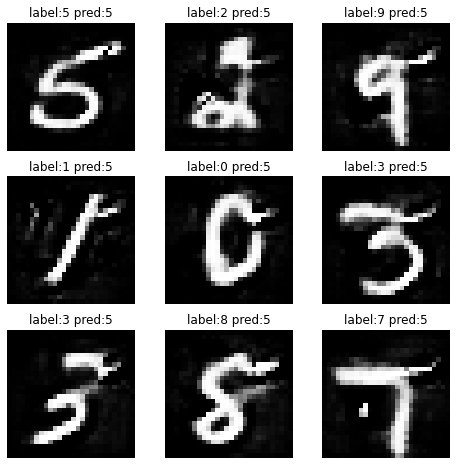

In [9]:
loss = nn.MSELoss()
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data_train), size=(1,)).item()
    img, label = data_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

    generate = model_AAE(img.unsqueeze(0).to(device))

    pred_raw =  minist_classifier(img.unsqueeze(0).to(device))
    pred_generate = minist_classifier(generate)

    _, idx_raw = pred_raw.sort(dim=1, descending=True)
    _, idx_generate = pred_generate.sort(dim=1, descending=True)
    print(idx_raw)
    print(idx_generate)
    print('loss:', loss(img.to(device), generate).item())

    plt.title('label:' + str(label) + ' ' + 'pred:' + str(idx_generate[0][0].item()))

    generate = generate.squeeze().cpu().detach().numpy()
    plt.imshow(generate, cmap="gray")
plt.show()

In [10]:
def count_attack_success(data_loader):
    success = 0
    total = len(data_loader.dataset)
    for batch, (X, _) in enumerate(data_loader):
        X = X.to(device)
        generate = model_AAE(X)
        pred_raw = minist_classifier(X)
        pred_generate = minist_classifier(generate)
        _, idx_raw = pred_raw.sort(dim=1, descending=True)
        _, idx_generate = pred_generate.sort(dim=1, descending=True)
        success += (idx_generate[:, 0] == target).sum().item()
        success -= (idx_raw[:, 0] == target).sum().item()
        total -= (idx_raw[:, 0] == target).sum().item()
    return success, total

attack_success_train, total_train = count_attack_success(data_loader_train)
attack_success_test, total_test = count_attack_success(data_loader_test)

print('attack success rate on training dataset:', attack_success_train / total_train)
print('attack success rate on testing dataset:', attack_success_test / total_test)

attack success rate on training dataset: 0.9578904932932639
attack success rate on testing dataset: 0.9316258107068264
